# SDP Project : CompuOpti Society Plannification

## Table of contents

1. [Load Instance](#1-load-instance)
2. [Model](#model)
3. [Variables](#variables)
4. [Constraints](#constraints)
5. [Objectives](#epsilon_choose)
6. [Optimize](#optimize)
7. [Results](#results)
8. [Visualization](#visualization)

## Frameworks

In [1]:
import gurobipy as gp
from gurobipy import GRB
import json
import numpy as np
import pandas as pd
import time
import tqdm
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
import plotly.graph_objects as go
from scipy.interpolate import griddata

## 1) Load Instance

In [2]:
start = time.time()

In [3]:
#path="instances/test.json"
path="instances/toy_instance.json"
#path="instances/medium_instance.json"
#path="instances/large_instance.json"

# JSON file
f = open (path, "r")
  
# Reading from file
data = json.loads(f.read())

In [4]:
# Gains
Gm=[]
for job in data["jobs"]:
    Gm.append(job['gain'])
Gm=np.array(Gm)

# Penalty
Pm=[]
for job in data["jobs"]:
    Pm.append(job['daily_penalty'])
Pm=np.array(Pm)

# Due Date
Dm=[]
for job in data["jobs"]:
    Dm.append(job['due_date'])
Dm=np.array(Dm)

# Penalty per day
Penalty=[]
for job in data["jobs"]:
    job_penalty=[]
    p=0
    for t in range(data["horizon"]):
        if (t>job["due_date"]-1):
            p+=job["daily_penalty"]
        job_penalty.append(p)
    Penalty.append(job_penalty)
Penalty=np.array(Penalty)

# Profit per day
Profit=[]
for job in data["jobs"]:
    job_benef=[]
    p=job['gain']
    for t in range(data["horizon"]):
        if (t>job["due_date"]-1):
            p-=job["daily_penalty"]
        job_benef.append(p)
    Profit.append(job_benef)
Profit=np.array(Profit)

# Vacations per day and per employee
Vacations=[]
for e in data["staff"]:
    e_planning=[]
    v=e['vacations']
    for t in range(data["horizon"]):
        if (t+1 in v):
            e_planning.append(1)
        else:
            e_planning.append(0)
    Vacations.append(e_planning)
Vacations=np.array(Vacations)

# Employee qualifications
Qualifications_staff=[]
for staff in data["staff"]:
    list_staff=[]
    for q in data["qualifications"]:
        if(q in staff["qualifications"]):
            list_staff.append(1)
        else:
            list_staff.append(0)
    Qualifications_staff.append(list_staff)
Qualifications_staff = np.array(Qualifications_staff)

# Jobs Qualifications
Qualifications_job=[]
for job in data["jobs"]:
    #working_days_per_qualification
    list_job=[]
    for q in data["qualifications"]:
        try:
            val=job['working_days_per_qualification'][q]
        except:
            val=0
        list_job.append(val)
    Qualifications_job.append(list_job)
Qualifications_job=np.array(Qualifications_job)

## 2) Model <a id='model'></a>

In [5]:
###
# MODEL
model = gp.Model()

horizon=data["horizon"]
qualifs=len(data["qualifications"])
projects=len(data["jobs"])
staffs=len(data["staff"])

Set parameter Username
Academic license - for non-commercial use only - expires 2023-12-29


## 3) Variables <a id='variables'></a>

### Common variables and 1st objective variables

In [6]:
###
# VARIABLES

# Planning 
Planning = model.addMVar(
                        shape=(staffs,horizon,projects,qualifs),
                        vtype=GRB.BINARY,
                        name="Planning"
                        )

# Delay 
Delay_project = model.addVars(
                                projects,
                                lb=0,
                                ub=horizon,
                                vtype=GRB.INTEGER,
                                name="Delay_project"
                            ) 

# End Date 
End_project = model.addVars(
                                projects,
                                lb = 1,
                                vtype=GRB.INTEGER,
                                name="End_project"
                            ) 

# Realisation Boolean
Realisation = model.addVars(
                                projects,
                                vtype=GRB.BINARY,
                                name="Realisation"
                            )


### 2nd objective variables

In [7]:
# Jobs done by one staff
jobs_staffeur = model.addMVar(shape=(staffs,projects),vtype=GRB.BINARY,name="jobs_staffeur")

# Sum of all jobs for one staff
sum_staff_jobs = model.addVars(staffs,vtype=GRB.INTEGER, name="sum_staff_jobs")  

### 3rd objective variables

In [8]:
# Begin 
Begin_project = model.addVars(
                                projects,
                                lb = 1,
                                vtype=GRB.INTEGER,
                                name="Begin_project"
                            ) 
# Lenght of one project
Lenght_project = model.addVars(
                                projects, 
                                vtype=GRB.INTEGER, 
                                name="Lenght_project"
                            )
#Lenght of the longest project
Max_duration_lenght = model.addVar(
                                    vtype = GRB.INTEGER,
                                    name = "Max_duration_lenght"
                                )

## 4) Constraints <a id='constraints'></a>

### Common constraints and 1st objective constraints

In [9]:
###
# CONSTRAINTS

#1 Unicity of affectation 
model.addConstrs(
    (gp.quicksum(gp.quicksum(Planning[staff][t]))<= 1
        for staff in range(len(data["staff"]))
        for t in range(data["horizon"])
    ),
    name="staff_qualif_unicity"
) 

#2 Vacations
model.addConstrs(
    (Planning[staff][t][job][qualif]<=1-Vacations[staff][t] 
        for staff in range(len(data["staff"]))
        for t in range(data["horizon"])
        for job in range(len(data["jobs"]))
        for qualif in range(len(data["qualifications"]))
    ),
    name="Vacations_constraint"
) 

#3 Qualification staff
model.addConstrs(
    (Planning[staff][t][job][qualif]<=Qualifications_staff[staff][qualif]
        for staff in range(len(data["staff"]))
        for t in range(data["horizon"])
        for job in range(len(data["jobs"]))
        for qualif in range(len(data["qualifications"]))
    ),
    name="Qualif_staff_constraint"
) 

# List with sum of timespend/qualifs/project
Max_temp_qualif_job=[]
for job in range(len(data["jobs"])):
    l_job=[]
    for qualif in range(len(data["qualifications"])):
        temp_qualif_job=0
        for t in range(data["horizon"]):
            for staff in range(len(data["staff"])):
                temp_qualif_job+=Planning[staff][t][job][qualif]
        l_job.append(temp_qualif_job)
    Max_temp_qualif_job.append(l_job)
Max_temp_qualif_job


#4 Qualifications cover => realisation
model.addConstrs(
        (Max_temp_qualif_job[job][qualif] >= Realisation[job] *  Qualifications_job[job][qualif]
            for job in range(len(data["jobs"]))
            for qualif in range(len(data["qualifications"]))
        ), name = "cover_qualif"
)

#5 Unicity realisation
model.addConstrs(
    (Max_temp_qualif_job[job][qualif] <= Qualifications_job[job][qualif]
            for job in range(len(data["jobs"]))
            for qualif in range(len(data["qualifications"]))
), name = "project_done_once")

#6 End project 
model.addConstrs(
   (Planning[staff][t][job][qualif] * t+1 <= End_project[job]
        for staff in range(len(data["staff"]))
        for t in range(data["horizon"])
        for job in range(len(data["jobs"]))
        for qualif in range(len(data["qualifications"]))
), name = "end_project_date")

#7 Delay 
model.addConstrs(
    (End_project[job] - Dm[job] <= Delay_project[job]
       for job in range(len(data["jobs"]))
    ), name="delay_project"
)

#8 We cannot start a job before day 0
for job in range(projects):
    model.addConstr(Begin_project[job] >= 1)



Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored


### 2nd objective constraints

In [10]:
#9
for staff in range(staffs):
    for job in range(projects):
        val=[]
        for t in range(horizon):
            for qualif in range(qualifs):
                val.append(Planning[staff][t][job][qualif])
        model.addConstr((jobs_staffeur[staff][job] == gp.max_(val)))

#10
for staff in range(staffs):
    model.addConstr((sum_staff_jobs[staff]==gp.quicksum(jobs_staffeur[staff])))

### 3rd objective constraints

In [11]:
#11
for job in range(projects):
    for t in range(horizon):
        for staff in range(staffs):
            for qualif in range(qualifs):
                model.addConstr(Begin_project[job] <= Planning[staff][t][job][qualif]*(t+1) +horizon*(1-Planning[staff][t][job][qualif]))

#12 Lenght of a project
for job in range(projects):
    model.addConstr(End_project[job] + 1 - Begin_project[job] <= Lenght_project[job])

#13 Max lenght of a project
for job in range(projects):
    model.addConstr(Lenght_project[job] <= Max_duration_lenght)

# Max or Epsilon  <a id='epsilon_choose'></a>

In [12]:
epsilon_constraint = False
model.ModelSense = GRB.MAXIMIZE

## 5) Objectives 

### Z1: Maximize Profit

In [13]:
# ici on suppose que si le projet n'est pas réalisé alors il n'est pas commencé donc pas de delay ?
# à vérifier ! (ajouter constraint #9 ?)
if epsilon_constraint == False:
    Z1 = gp.quicksum((Realisation.values()*Gm)-(Pm*Delay_project.values()))
    model.setObjectiveN(
        Z1, 
        index=0, 
        priority=2, 
        name='Profit')

### Z2: Minimize Number of Projects per Employee

In [14]:
if epsilon_constraint == False:
    for staff in range(staffs):
        model.setObjectiveN(sum_staff_jobs[staff], 
                            index=1+staff, 
                            priority=1, 
                            weight=-1,
                            name='Staff_Assign')  #weight = -1 to minimize


### Z3: Minimize Realisation Time

In [15]:
if epsilon_constraint == False:
    model.setObjectiveN(-Max_duration_lenght,
                        index = 2,
                        priority = 0,
                        name='Max_Duration')

## 6) Optimize <a id='optimize'></a>

### Optimize without epsilon

In [16]:
if epsilon_constraint == False:
    model.optimize()
#My Docker : Intel(R) Xeon(R) CPU E5-2640 v4 @ 2.40GHz
#Daniel :    Intel(R) Core(TM) i5-8259U CPU @ 2.30GHz
#PA :        Intel(R) Core(TM) i7-9750H CPU @ 2.60GHz

Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (mac64[x86])

CPU model: Intel(R) Core(TM) i5-8259U CPU @ 2.30GHz
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 968 rows, 269 columns and 2003 nonzeros
Model fingerprint: 0xd1804b32
Model has 15 general constraints
Variable types: 0 continuous, 269 integer (245 binary)
Coefficient statistics:
  Matrix range     [1e+00, 4e+00]
  Objective range  [1e+00, 2e+01]
  Bounds range     [1e+00, 5e+00]
  RHS range        [1e+00, 5e+00]

---------------------------------------------------------------------------
Multi-objectives: starting optimization with 4 objectives (3 combined) ...
---------------------------------------------------------------------------

Multi-objectives: applying initial presolve ...
---------------------------------------------------------------------------

Presolve removed 793 rows and 140 columns
Presolve time: 0.01s
Presolved: 175 rows and 129 columns
---------------

### Optimize with epsilon

In [17]:
if epsilon_constraint:
    epsilon_2nd_cst =  np.arange(projects, 0, -1)
    epsilon_3rd_cst =  np.arange(horizon, 0, -1)
    pareto_points = []

    for job in tqdm.tqdm(epsilon_2nd_cst):
        print(job)
        for t in epsilon_3rd_cst:
            
            for staff in range(staffs):
                model.addConstr( sum_staff_jobs[staff] <= job , name = f"max_switch_{job}_{staff}")

            model.addConstr( Max_duration_lenght <= t , name = "max_len")
            model.addConstr( Max_duration_lenght >= t , name = "max_len2")
            
            Z1 = gp.quicksum((Realisation.values()*Gm)-(Pm*Delay_project.values()))
            model.setObjective(
                Z1,
                GRB.MAXIMIZE
            )
            
            model.params.outputflag = 0
            model.optimize()
            for staff in range(staffs):
                model.remove((model.getConstrByName(f"max_switch_{job}_{staff}")))
                
            model.remove((model.getConstrByName("max_len")))
            model.remove((model.getConstrByName("max_len2")))

            Z1 = 0
            sum_assignation=0
            moyenne_assignation=0
            for staff in range(staffs):
                sum_assignation+=sum_staff_jobs[staff].x
        
            moyenne_assignation=sum_assignation/len(sum_staff_jobs)
            
            pareto_points.append((model.objVal, round(moyenne_assignation,2), Max_duration_lenght.X))


## 7) Results <a id='results'></a>

In [18]:
end = time.time()
print("Time taken: ", round(end - start,2), "seconds || ",round((end - start)/60,2), "minutes" )
# instance | time | profit, moyenne_assignation, Max_duration_lenght
# toy :  3 s ||  65, 2, 3
# medium : 76.94 minutes ||  413, 4.4, 12
# large : 3,7 min

Time taken:  1.59 seconds ||  0.03 minutes


### With epsilon

In [19]:
if epsilon_constraint:
    Profit = [i[0] for i in pareto_points]
    Assignation = [i[1] for i in pareto_points]
    Duration = [i[2] for i in pareto_points]

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    surf=ax.plot_trisurf(Assignation, Duration, Profit, cmap=cm.jet, linewidth=0.1)

    ax.set_xlabel('Moyenne Assignation')
    ax.set_ylabel('Max duration')
    ax.set_zlabel('Profit')
    fig.colorbar(surf, shrink=0.5, aspect=5)
    plt.show()

In [20]:
if epsilon_constraint:
    x = Assignation
    y = Duration
    z = Profit

    xi = np.linspace(min(x), max(x), 100)
    yi = np.linspace(min(y), max(y), 100)

    X,Y = np.meshgrid(xi,yi)

    Z = griddata((x,y),z,(X,Y), method='cubic')

    fig = go.Figure(go.Surface(x=xi,y=yi,z=Z,surfacecolor=Z, colorscale='jet'))
    fig.update_layout(scene=dict(xaxis_title='Moyenne Assignation',
                                 yaxis_title='Max duration',
                                 zaxis_title='Profit'))
    fig.show()

### Without epsilon

##### Z1

In [21]:
# Z1
print("Z1: Maximize Profit\n")
print("Solution || Best ")
print(" ",model.objVal,"  || ",Gm.sum())
print("\nDetails: Gain - Delay * Daily Penalty\n")
for job in range(projects):
    if(int(Realisation[job].x)==1):
        print(data["jobs"][job]["name"],":",data["jobs"][job]["gain"],"-",int(Delay_project[job].x),"*",data["jobs"][job]["daily_penalty"])
    else:
        print(data["jobs"][job]["name"],": Not Done")
print("------------")
print("Total =",model.objVal)


Z1: Maximize Profit

Solution || Best 
  65.0   ||  80

Details: Gain - Delay * Daily Penalty

Job1 : 20 - 0 * 3
Job2 : Not Done
Job3 : 15 - 0 * 3
Job4 : 20 - 0 * 3
Job5 : 10 - 0 * 3
------------
Total = 65.0


##### Z2

In [22]:
# Z2
print("Z2: Minimize Number of Projects per Employee\n")
print("Staff || Job(s) ||  Name")
for i in range(len(data["staff"])):
    print(" ",i,"  ||  ",int(sum_staff_jobs[i].x),"   || ",data["staff"][i]["name"])

Z2: Minimize Number of Projects per Employee

Staff || Job(s) ||  Name
  0   ||   2    ||  Olivia
  1   ||   2    ||  Liam
  2   ||   2    ||  Emma


##### Z3

In [23]:
days_work_on_job={}
projects_duration=[]
for job in range(projects):
    val_V=[]
    for t in range(horizon):
        for staff in range(staffs):
            for qualif in range(qualifs):
                if(int(Planning[staff][t][job][qualif].x)>0):
                    val_V.append(t+1)
    days_work_on_job[job+1]=np.array(val_V)


for i in days_work_on_job.keys():
    projects_duration.append(len(np.unique(days_work_on_job[i])))

In [24]:
# Z3
print("Z3: Minimize Realisation Time\n")
print("  Job   || Begin ||  End  || Delta")
for i in range(len(data["jobs"])):
    if int(Begin_project[i].x) == 1:
        print("  ",i+1,"   || ",0,"   ||  ",int(End_project[i].x*Realisation[i].x),"  || ", projects_duration[i])
    else:
        print("  ",i+1,"   || ",int(Begin_project[i].x),"   ||  ",int(End_project[i].x*Realisation[i].x),"  || ", projects_duration[i])            

Z3: Minimize Realisation Time

  Job   || Begin ||  End  || Delta
   1    ||  0    ||   3   ||  3
   2    ||  0    ||   0   ||  0
   3    ||  3    ||   4   ||  2
   4    ||  0    ||   3   ||  3
   5    ||  4    ||   5   ||  2


## 8) Verifying that the constraints are met

In [25]:
#Couverture qualif
print("- Couverture Qualifications -\n")
for job in range(len(data["jobs"])):
    print(data["jobs"][job]["name"],int(Realisation[job].x)==1)
    for qualif in range(qualifs):
        val=0
        for t in range(horizon):
            for staff in range(staffs):
                val+=int(Planning[staff][t][job][qualif].x)
        print(" .",data["qualifications"][qualif],val)
    print("Expected",Qualifications_job[job])
    print("---")

- Couverture Qualifications -

Job1 True
 . A 1
 . B 1
 . C 1
Expected [1 1 1]
---
Job2 False
 . A 0
 . B 0
 . C 0
Expected [1 2 0]
---
Job3 True
 . A 1
 . B 0
 . C 2
Expected [1 0 2]
---
Job4 True
 . A 0
 . B 2
 . C 1
Expected [0 2 1]
---
Job5 True
 . A 0
 . B 0
 . C 2
Expected [0 0 2]
---


In [26]:
# Due dates
print("- Due Dates -\n")
print("Project || Expected || End || Delay")
for i in range(len(data["jobs"])):
    print("  ",i+1,"   ||    ",data["jobs"][i]["due_date"],"   || ",int(End_project[i].x*Realisation[i].x)," || ",int(Delay_project[i].x))

- Due Dates -

Project || Expected || End || Delay
   1    ||     3    ||  3  ||  0
   2    ||     3    ||  0  ||  0
   3    ||     4    ||  4  ||  0
   4    ||     3    ||  3  ||  0
   5    ||     5    ||  5  ||  0


In [27]:
# Unicité affectation et congé
print("- Unicité Affectation et Congés -\n")
for t in range(horizon):
    print("Jour",t+1)
    for staff in range(staffs):
        val=0
        for job in range(len(data["jobs"])):
            for qualif in range(qualifs):
                val+=int(Planning[staff][t][job][qualif].x)
        vacation= t+1 in data["staff"][staff]["vacations"]
        if(vacation):
            print(" .",data["staff"][staff]["name"],val,"Vacation")
        else:
            print(" .",data["staff"][staff]["name"],val)
    print("---")

- Unicité Affectation et Congés -

Jour 1
 . Olivia 1
 . Liam 0 Vacation
 . Emma 1
---
Jour 2
 . Olivia 1
 . Liam 1
 . Emma 0 Vacation
---
Jour 3
 . Olivia 1
 . Liam 1
 . Emma 1
---
Jour 4
 . Olivia 1
 . Liam 1
 . Emma 1
---
Jour 5
 . Olivia 1
 . Liam 0
 . Emma 0
---


## 8) Visualization <a id='visualization'></a>

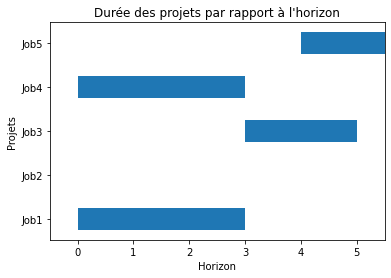

In [28]:
projects_names = [job["name"] for job in data["jobs"]]
starts_dates=[Begin_project[i].x for i in range(len(data["jobs"]))]
starts_dates = [i-1 if i == 1 else i for i in starts_dates ]
plt.barh(projects_names, projects_duration,left= starts_dates, height=0.5)

plt.xlim(-0.5, horizon+0.5)
plt.ylabel('Projets')
plt.xlabel('Horizon')
plt.title("Durée des projets par rapport à l'horizon")

plt.show()

In [29]:
res={}
res_V={}
for job in range(projects):
    val=[]
    val_V=[]
    for t in range(horizon):
        for staff in range(staffs):
            for qualif in range(qualifs):
                if(int(Planning[staff][t][job][qualif].x)>0):
                    val.append((t,staff,qualif))
                    val_V.append((t+1,data["staff"][staff]["name"],data['qualifications'][qualif]))
    res[job]=val
    res_V[job+1]=val_V

res_V

{1: [(1, 'Emma', 'C'), (2, 'Liam', 'A'), (3, 'Liam', 'B')],
 2: [],
 3: [(3, 'Emma', 'C'), (4, 'Liam', 'A'), (4, 'Emma', 'C')],
 4: [(1, 'Olivia', 'B'), (2, 'Olivia', 'B'), (3, 'Olivia', 'C')],
 5: [(4, 'Olivia', 'C'), (5, 'Olivia', 'C')]}

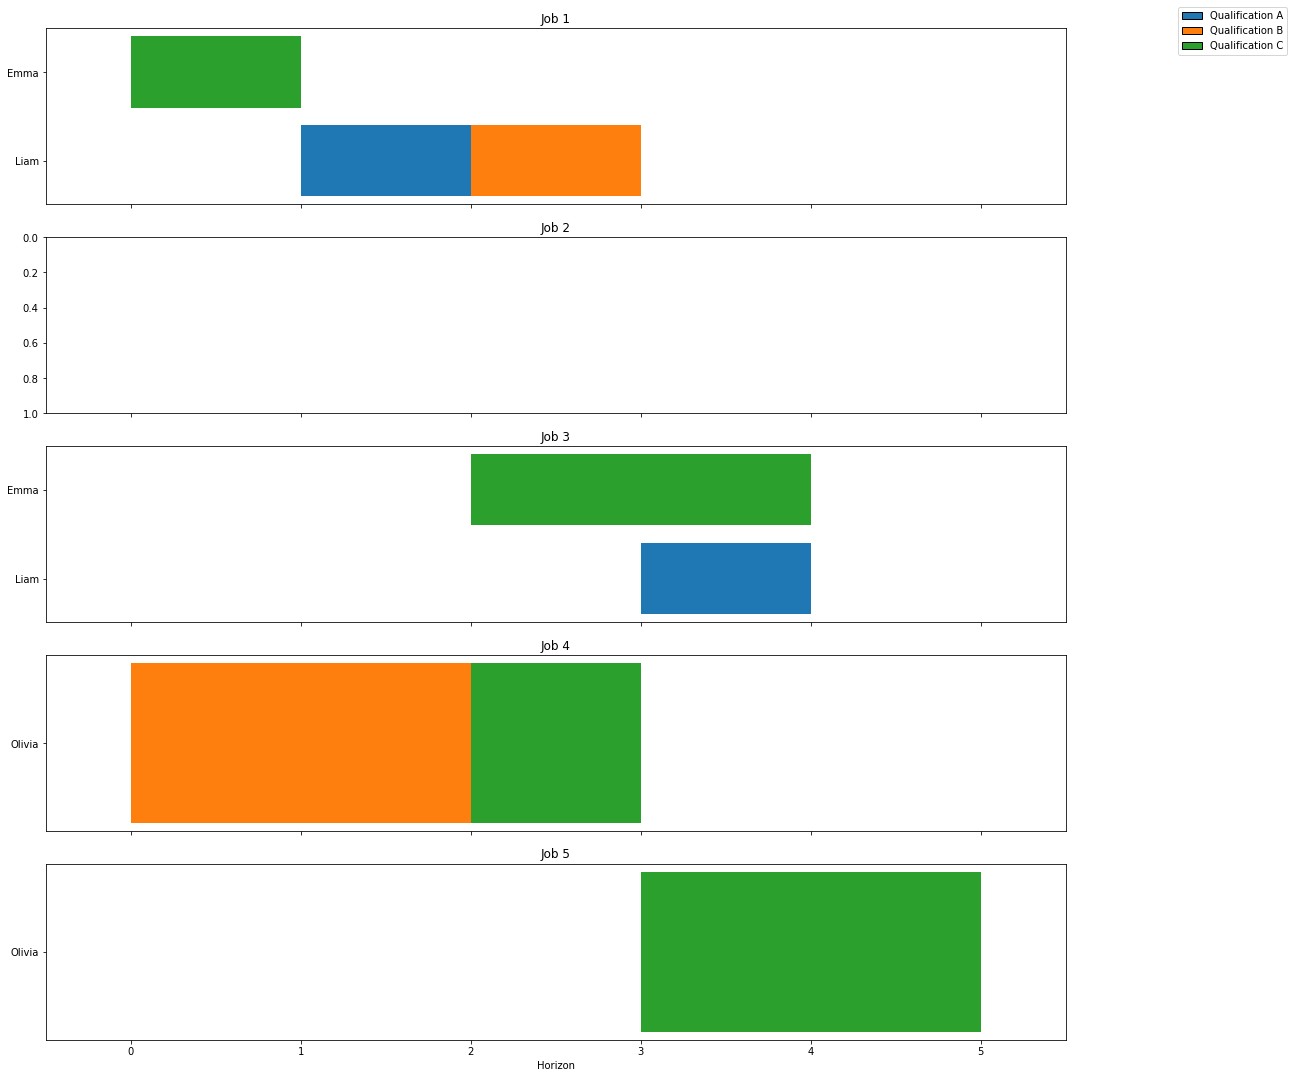

In [30]:
staff_names=[data["staff"][i]["name"] for i in range(staffs)]

fig, axs = plt.subplots(projects, 1, figsize=(15, 15), sharex=True)

color_map = {}
for i in range(qualifs):
    color_map[i]='C'+str(i)

for job, job_data in res.items():
    for day_data in job_data:
        t=day_data[0]
        staff_data=day_data[1]
        qualif_data=day_data[2]
        axs[job].barh(data["staff"][staff_data]["name"], 1, left=t, color=color_map[qualif_data])
    axs[job].set_title(f'Job {job+1}')
    axs[job].invert_yaxis()
    
handles = [plt.Rectangle((0, 0), 1, 1, color=color, ec="k") for color in color_map.values()]
labels = [f"Qualification {data['qualifications'][i]}" for i in color_map.keys()]
fig.legend(handles, labels, loc='upper right', bbox_to_anchor=(1.2, 1))

plt.xlim(-0.5, horizon+0.5)
plt.xlabel("Horizon")
plt.tight_layout()
plt.savefig("Results/jpg/planning_"+path.split("/")[-1].split('.')[0]+".jpg",bbox_inches='tight')
plt.show()


In [31]:
# 4D matrix, Gurobi variables extraction
matrix = np.array([[element.x for element in row] for row in Planning]).reshape(staffs, horizon, projects, qualifs)

# 4D matrix to dataframe
df = pd.DataFrame(np.reshape(matrix, (staffs * horizon, projects * qualifs)),
                  columns=[f"Project {i+1} - Qualification {j+1}" for i in range(projects) for j in range(qualifs)],
                  index=[f"Staff {i+1} - Horizon {j+1}" for i in range(staffs) for j in range(horizon)])

df.loc['sum_row'] = df.sum()

df['sum_column'] = df.sum(axis=1)

df.to_csv("Results/csv/planning_"+path.split("/")[-1].split('.')[0]+".csv",sep=";")
df.to_excel("Results/xlsx/planning_"+path.split("/")[-1].split('.')[0]+".xlsx")


In [32]:
def highlight_cells(val):
    color = 'yellow' if val == 1 else 'red' if val > 1 else ''
    return 'background-color: %s' % color

df.style.applymap(highlight_cells)

,Project 1 - Qualification 1,Project 1 - Qualification 2,Project 1 - Qualification 3,Project 2 - Qualification 1,Project 2 - Qualification 2,Project 2 - Qualification 3,Project 3 - Qualification 1,Project 3 - Qualification 2,Project 3 - Qualification 3,Project 4 - Qualification 1,Project 4 - Qualification 2,Project 4 - Qualification 3,Project 5 - Qualification 1,Project 5 - Qualification 2,Project 5 - Qualification 3,sum_column
Staff 1 - Horizon 1,0.000000,0.000000,-0.000000,-0.000000,-0.000000,0.000000,0.000000,0.000000,-0.000000,0.000000,1.000000,-0.000000,0.000000,0.000000,-0.000000,1.000000
Staff 1 - Horizon 2,0.000000,-0.000000,-0.000000,-0.000000,-0.000000,0.000000,-0.000000,0.000000,-0.000000,0.000000,1.000000,-0.000000,0.000000,0.000000,-0.000000,1.000000
Staff 1 - Horizon 3,0.000000,-0.000000,0.000000,-0.000000,-0.000000,0.000000,-0.000000,0.000000,-0.000000,0.000000,-0.000000,1.000000,0.000000,0.000000,-0.000000,1.000000
Staff 1 - Horizon 4,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,0.000000,-0.000000,0.000000,0.000000,0.000000,-0.000000,-0.000000,0.000000,0.000000,1.000000,1.000000
Staff 1 - Horizon 5,-0.000000,-0.000000,-0.000000,-0.000000,0.000000,0.000000,-0.000000,0.000000,-0.000000,0.000000,-0.000000,-0.000000,0.000000,0.000000,1.000000,1.000000
Staff 2 - Horizon 1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Staff 2 - Horizon 2,1.000000,0.000000,0.000000,-0.000000,-0.000000,0.000000,-0.000000,0.000000,0.000000,0.000000,-0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
Staff 2 - Horizon 3,-0.000000,1.000000,0.000000,-0.000000,0.000000,0.000000,-0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
Staff 2 - Horizon 4,-0.000000,-0.000000,0.000000,-0.000000,-0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,-0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
Staff 2 - Horizon 5,-0.000000,-0.000000,0.000000,0.000000,0.000000,0.000000,-0.000000,0.000000,0.000000,0.000000,-0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


## 9) Explo

In [33]:
sum_assignation=0
moyenne_assignation=0
for staff in range(staffs):
    sum_assignation+=sum_staff_jobs[staff].x

moyenne_assignation=sum_assignation/len(sum_staff_jobs)

print(model.objVal, round(moyenne_assignation,2), Max_duration_lenght.x)

65.0 2.0 3.0


In [34]:
# Save the model to a file
model.write("Results/gurobi_models/model_"+path.split("/")[-1].split('.')[0]+".rlp")

In [35]:
def dominated_p(pareto_points):
    dominated_points = []
    n = len(points)
    for i in range(n):
        for j in range(n):
            if i == j:
                continue
            if all(points[j][k] <= points[i][k] for k in range(3)) and any(points[j][k] < points[i][k] for k in range(3)):
                dominated_points.append(i)
                break
    return [point for i, point in enumerate(points) if i not in dominated_points]
